<a href="https://colab.research.google.com/github/kamileo96/GNN-Tracking/blob/main/GNN_muonE_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [ ]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Successfully uninstalled torchvision-0.14.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 969.8 kB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [ ]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [ ]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [ ]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
"""
!pip install torch-geometric
!pip install torch-sparse
!pip install torch-scatter"""
# MW corrected

!pip install torch-geometric \
  torch-sparse==0.6.13 \
  torch-scatter==2.0.9 \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 16.6 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=286aeb544260dda34cfa8f45248a771053406b89118e0cae71ab6c472fd6f793
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Problem

Toy Data (changed to 3D)

In [ ]:
import numpy as np

minz = 550

def GenerateIntersection3D(line_params, z):
  #Generates intersections with a plane at z=z
  x0, y0, z0, theta, phi = line_params
  t = (z-z0)/np.cos(theta)
  x = x0 + t * np.cos(phi) * np.sin(theta)
  y = y0 + t * np.sin(phi) * np.sin(theta)
  return np.array([x,y,z])

def GenerateTracks(n):
  """
  #for initial lines not along z axis
  thetas = np.abs(np.random.normal(0, 5/180*np.pi, n))
  phis = np.random.rand(n)*2*np.pi
  r0 = np.random.rand((n,3))
  """
  #initial line along z axis
  #z of colision (probably the 200 is a bit much)
  z0s = minz + np.random.rand(n)*200
  phis = np.random.rand(n)*2*np.pi
  #the toy muon would have a small theta:
  thetas1 = np.abs(np.random.normal(0, 10/180*np.pi, n)) + 7/180*np.pi
  #and the electron would have a larger one (lets say around 40 degrees)
  thetas2 = np.abs(np.random.normal(40, 5/180*np.pi, n))
  #this could be estimated better but there is no need
  r0s = np.array([np.zeros(n), np.zeros(n), z0s])
  line_params_1 = np.concatenate((r0s, [thetas1, phis]), axis=0).T
  line_params_2 = np.concatenate((r0s, [thetas2, -phis]), axis=0).T
  return line_params_1, line_params_2

def ShuffleIndexSwap(Edges, nIdx):
  #changes edges according to the shuffled index
  my_dict = {}
  for i in range(len(nIdx)):
    my_dict[i] = nIdx[i]
  
  return np.vectorize(my_dict.get)(Edges)

def gen3D_edge_events(n, layerz):
  lp1s, lp2s = GenerateTracks(n)
  layers_before = layerz[layerz < minz]
  layers_after = layerz[layerz >= minz]
  points_before = np.zeros((len(layers_before),3))
  points_before[2] = layers_before
  events_data = []
  for lp1, lp2 in zip(lp1s, lp2s):
    p1s = GenerateIntersection3D(lp1, layers_after)
    p2s = GenerateIntersection3D(lp2, layers_after)

    x = np.concatenate((points_before, p1s, p2s), axis=1).T

    #this connects the graph like this: ---<===
    #and then adds fake edges between two tracks 'X'
    #         3 - 4 - 5
    # -0-1-2<   X   X
    #         6 - 7 - 8
    true_edges = [[i, i+1] for i in range(len(x)-1)]
    true_edges.append([len(layers_before)-1, len(layers_before) + len(layers_after)])
    true_edges.remove([len(layers_before) + len(layers_after) - 1, len(layers_before) + len(layers_after)])

    fake_edges = []
    for i in range(len(layers_after)-1):
      a = len(layers_before) + i
      b = len(layers_before) + len(layers_after) + i
      fake_edges.append([a, b + 1])
      fake_edges.append([b, a + 1])
    edges = np.array(true_edges + fake_edges).T
    y = np.append(np.ones(len(true_edges)), np.zeros(len(fake_edges)))

    #as of now the data is not shuffled at all, so:
    #shuffling points:
    nIdx = np.arange(len(x))
    np.random.shuffle(nIdx)
    edges = ShuffleIndexSwap(edges, nIdx)
    x[nIdx] = x.copy()
    #shuffling edges:
    
    neidx = np.arange(len(y))
    np.random.shuffle(neidx)
    edges[0] = edges[0][neidx]
    edges[1] = edges[1][neidx]
    y = y[neidx]
    data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edges), y = torch.from_numpy(y))
    events_data.append(data)
  return events_data






In [ ]:
import plotly.express as px
def plot_toy_graph_3D(event, pyplot=False):
    plt.figure(figsize=(10,5))
    x, y, z = event.x[:,0].numpy(), event.x[:,1].numpy(), event.x[:,2].numpy()
    e = event.edge_index.numpy()
    if pyplot:
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      for j,i1,i2 in zip(e[0],e[1]):
        ax.plot([x[i1], x[i2]], [y[i1], y[i2]], [z[i1], z[i2]], c='b')
      #ax.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], [z[e[0,:]], z[e[1,:]]], c='b')
      ax.scatter(x, y, z, c='k')
    else:
      #fig = px.scatter_3d(data[0], 0, 1, 2)
      df = pd.DataFrame([], columns=['x', 'y', 'z', 'label'])
      for j,i1,i2 in zip(range(len(e[0])),e[0],e[1]):

        df2 = pd.DataFrame([[x[i1], y[i1], z[i1], j], [x[i2], y[i2], z[i2], j]], columns=['x', 'y', 'z', 'label'])
        df = df.append(df2, ignore_index=True)
      fig = px.line_3d(df, x='x', y='y', z='z', line_group='label')
      fig.show()


In [ ]:


layerz = np.array([-16, 131, 477, 832, 1146, 1479.6, 1973 ])
#print(gen3D_edge_events(2,layerz))
data = gen3D_edge_events(1,layerz)

print(data)
plot_toy_graph_3D(data[0], False)
#fig = plt.figure()
#fig = px.scatter_3d(data[0], 0, 1, 2)
#fig.show()

[Data(x=[11, 3], edge_index=[2, 16], y=[16])]


<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
train_size, test_size = 1000, 1000
layerz = np.array([-16, 131, 477, 832, 1146, 1479.6, 1973 ])
train_dataset = gen3D_edge_events(train_size,layerz)
test_dataset = gen3D_edge_events(test_size,layerz)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [ ]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  0.6


## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [ ]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

### Training on Toy Data

In [ ]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [ ]:
weight = 2

m_configs = {"input_dim": 3, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
for epoch in range(50):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))



Epoch: 1, Accuracy: 0.5303
Epoch: 2, Accuracy: 0.6250
Epoch: 3, Accuracy: 0.6139
Epoch: 4, Accuracy: 0.5958
Epoch: 5, Accuracy: 0.5864
Epoch: 6, Accuracy: 0.6355
Epoch: 7, Accuracy: 0.6655
Epoch: 8, Accuracy: 0.7021
Epoch: 9, Accuracy: 0.7379
Epoch: 10, Accuracy: 0.7907
Epoch: 11, Accuracy: 0.8522
Epoch: 12, Accuracy: 0.8811
Epoch: 13, Accuracy: 0.8946
Epoch: 14, Accuracy: 0.9109
Epoch: 15, Accuracy: 0.9185
Epoch: 16, Accuracy: 0.9243
Epoch: 17, Accuracy: 0.9280
Epoch: 18, Accuracy: 0.9315
Epoch: 19, Accuracy: 0.9366
Epoch: 20, Accuracy: 0.9413
Epoch: 21, Accuracy: 0.9456
Epoch: 22, Accuracy: 0.9476
Epoch: 23, Accuracy: 0.9523
Epoch: 24, Accuracy: 0.9511
Epoch: 25, Accuracy: 0.9550
Epoch: 26, Accuracy: 0.9557
Epoch: 27, Accuracy: 0.9570
Epoch: 28, Accuracy: 0.9596
Epoch: 29, Accuracy: 0.9617
Epoch: 30, Accuracy: 0.9627
Epoch: 31, Accuracy: 0.9652
Epoch: 32, Accuracy: 0.9655
Epoch: 33, Accuracy: 0.9663
Epoch: 34, Accuracy: 0.9677
Epoch: 35, Accuracy: 0.9676
Epoch: 36, Accuracy: 0.9690
E

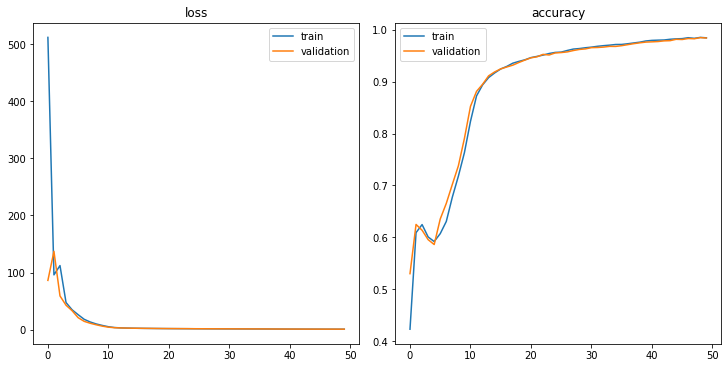

In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [ ]:
def plot_toy_classified_3D(event, preds, cut=0.5, pyplot=False):
    plt.figure(figsize=(10,5))
    x, y, z = event.x[:,0].numpy(), event.x[:,1].numpy(), event.x[:,2].numpy()
    y_true = event.y.numpy()
    y_pred = preds.detach().numpy()
    e = event.edge_index.numpy()
    if pyplot:
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      for j,i1,i2 in zip(e[0],e[1]):
        ax.plot([x[i1], x[i2]], [y[i1], y[i2]], [z[i1], z[i2]], c='b')
      #ax.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], [z[e[0,:]], z[e[1,:]]], c='b')
      ax.scatter(x, y, z, c='k')
    else:
      fig = plt.figure()
      #fig = px.scatter_3d(data[0], 0, 1, 2)
      df = pd.DataFrame([], columns=['x', 'y', 'z', 'label', 'color', 'pred']) #label is not actually label, but edge index.
      for j,i1,i2 in zip(range(len(e[0])),e[0],e[1]):
        yt = y_true[j]
        yp = y_pred[j]
        color_value = 0
        #the colors change dynamicaly, but 0 means correct edge,
        #1 correct no edge, 2 edge not detected, 3 edge falsely detected
        
        if yt:
          if yp > cut: color_value = 0
          else: color_value = 2
        else:
          if yp > cut: color_value = 3
          else: color_value = 1
        df2 = pd.DataFrame([[x[i1], y[i1], z[i1], j, color_value, yp], [x[i2], y[i2], z[i2], j, color_value, yp]], columns=['x', 'y', 'z', 'label', 'color', 'pred'])
        df = df.append(df2, ignore_index=True)
      fig = px.line_3d(df, x='x', y='y', z='z', line_group='label', color='color')
      fig.show()

In [ ]:
for k in range(1000):
  data = test_loader.dataset[k].to(device)
  preds = torch.sigmoid(model(data)).to('cpu')
  y_true = data.y.numpy()
  y_pred = preds.detach().numpy() > 0.5
  y_pred = y_pred.astype(int)
  if (y_true == y_pred).sum()/len(y_true) > 0. and (y_true == y_pred).sum()/len(y_true) < 0.99: 
    
    print(y_true)
    print(y_pred)
    plot_toy_classified_3D(data, preds)
    break

[1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
[1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0]


<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
k = 10
data = test_loader.dataset[k].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
y_true = data.y.numpy()
y_pred = preds.detach().numpy() > 0.5
y_pred = y_pred.astype(int)
print(y_true)
print(y_pred)
plot_toy_classified_3D(data, preds)

[0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
[0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1]


<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests. Try playing with more hidden node and edge dimensions (e.g. 64) and see if the message passing iterations can improve the performance.

Epoch: 1, Accuracy: 0.5088
Epoch: 2, Accuracy: 0.5764
Epoch: 3, Accuracy: 0.5764
Epoch: 4, Accuracy: 0.5764
Epoch: 5, Accuracy: 0.5764
Epoch: 6, Accuracy: 0.5764
Epoch: 7, Accuracy: 0.5764
Epoch: 8, Accuracy: 0.5764
Epoch: 9, Accuracy: 0.5764
Epoch: 10, Accuracy: 0.5802
Epoch: 11, Accuracy: 0.5929
Epoch: 12, Accuracy: 0.5962
Epoch: 13, Accuracy: 0.6178
Epoch: 14, Accuracy: 0.6250
Epoch: 15, Accuracy: 0.6160
Epoch: 16, Accuracy: 0.6253
Epoch: 17, Accuracy: 0.6303
Epoch: 18, Accuracy: 0.6238
Epoch: 19, Accuracy: 0.6331
Epoch: 20, Accuracy: 0.6225
Epoch: 21, Accuracy: 0.6494
Epoch: 22, Accuracy: 0.6107
Epoch: 23, Accuracy: 0.6811
Epoch: 24, Accuracy: 0.6324
Epoch: 25, Accuracy: 0.7029
Epoch: 26, Accuracy: 0.7245
Epoch: 27, Accuracy: 0.6588
Epoch: 28, Accuracy: 0.8863
Epoch: 29, Accuracy: 0.8582
Epoch: 30, Accuracy: 0.8261
Epoch: 31, Accuracy: 0.8573
Epoch: 32, Accuracy: 0.8889
Epoch: 33, Accuracy: 0.9489
Epoch: 34, Accuracy: 0.9385
Epoch: 35, Accuracy: 0.9565
Epoch: 36, Accuracy: 0.9314
E

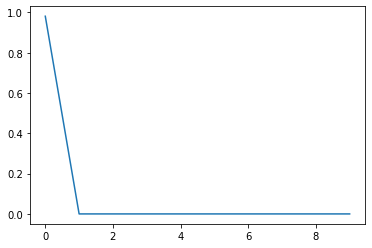

In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
best_acc = np.zeros(10)
for i in range(1,2): #for i in range(1,11): # shorten to 2 iterations to speed up
    m_configs = {"input_dim": 3, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": i, "layer_norm": True}
    model = MPNN_Network(**m_configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
    for epoch in range(50):
        ep += 1  
        model.train()
        acc, total_loss = train(model, train_loader, optimizer)
        t_loss_v.append(total_loss)
        t_acc_v.append(acc)

        model.eval()
        acc, total_loss = evaluate(model, test_loader)
        if acc > best_acc[i-1]: best_acc[i-1] = acc
        v_loss_v.append(total_loss)
        v_acc_v.append(acc)

        print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))
plt.plot(np.arange(len(best_acc)), best_acc)

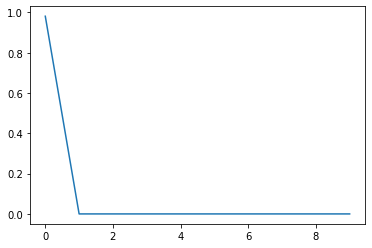

In [ ]:
plt.plot(np.arange(len(best_acc)), best_acc)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [16]:
import numpy as np, pandas as pd
def xyz_from_hits(layer_info):
  #layer_info - dataframe consisting of two rows that contain information about two closeby layers
  #returns x,y,z array
  df = layer_info.sort_values('hitType')
  z = df['layerZ'].mean()
  #knowing df is sorted:
  #this can be changed when i know how stereo layers work
  tag = df['hitType'].tolist()
  pos = df['hitPos'].tolist()
  s = np.sqrt(2)
  if (tag == [0, 1]):
    x,y = pos
  elif (tag == [0, 2]):
    #assuming x+y/sqrt2
    x = pos[0]
    y = pos[1]*s - x
  elif (tag == [0, 3]):
    #-y+x/sqrt2
    x = pos[0]
    y = -pos[1]*s - x
  elif (tag == [1, 2]):
    #assuming x+y/sqrt2
    y = pos[0]
    x = pos[1]*s - y
  elif (tag == [1, 3]):
    #-y+x/sqrt2
    y = pos[0]
    x = pos[1]*s + y
  try:
    return np.array([x, y, z])
  except:
    print('Unknown hit type')
    return np.array([0, 0, z])

def generate_points(sub_event, layer_groups):
  #event with only one track
  points = np.empty((0,3))
  for group in layer_groups:
    points = np.append(points, [xyz_from_hits(sub_event[sub_event['layerIndex'].isin(group)])], axis=0)
  return points

def generate_event_possible_points(event, two_layer_groups):
  #assuming event is sorted by layer index
  #layer groups are layer indices of closeby layers, grouped into two lists for before and after
  df = event.sort_values('trackID')
  df0, df1, df2 = [df_i.sort_values('layerIndex') for _, df_i in df.groupby(df['trackID'])]
  p0s = generate_points(df0, two_layer_groups[0])
  p1s = generate_points(df1, two_layer_groups[1])
  p2s = generate_points(df2, two_layer_groups[1])

  #generating ghost hits as particle 3 ( ghoston :) )
  #there are two ghost points at each layer group: a and b
  layers1, layers2 = np.transpose(two_layer_groups[1])
  df3a = pd.concat([df1[df1['layerIndex'].isin(layers1)], df2[df2['layerIndex'].isin(layers2)]]).sort_values('layerIndex')
  df3b = pd.concat([df1[df1['layerIndex'].isin(layers2)], df2[df2['layerIndex'].isin(layers1)]]).sort_values('layerIndex')
  
  p3as = generate_points(df3a, two_layer_groups[1])
  p3bs = generate_points(df3b, two_layer_groups[1])
  return p0s, p1s, p2s, p3as, p3bs

def ShuffleIndexSwap(Edges, nIdx):
  #changes edges according to the shuffled index
  my_dict = {}
  for i in range(len(nIdx)):
    my_dict[i] = nIdx[i]
  
  return np.vectorize(my_dict.get)(Edges)


def gen3D_edge_events(event):
  #event - pandas dataframe of one event
  #tbc
  lp1s, lp2s = GenerateTracks(n)
  layers_before = layerz[layerz < minz]
  layers_after = layerz[layerz >= minz]
  points_before = np.zeros((len(layers_before),3))
  points_before[2] = layers_before
  events_data = []
  for lp1, lp2 in zip(lp1s, lp2s):
    p1s = GenerateIntersection3D(lp1, layers_after)
    p2s = GenerateIntersection3D(lp2, layers_after)

    x = np.concatenate((points_before, p1s, p2s), axis=1).T

    #this connects the graph like this: ---<===
    #and then adds fake edges between two tracks 'X'
    #         3 - 4 - 5
    # -0-1-2<   X   X
    #         6 - 7 - 8
    true_edges = [[i, i+1] for i in range(len(x)-1)]
    true_edges.append([len(layers_before)-1, len(layers_before) + len(layers_after)])
    true_edges.remove([len(layers_before) + len(layers_after) - 1, len(layers_before) + len(layers_after)])

    fake_edges = []
    for i in range(len(layers_after)-1):
      a = len(layers_before) + i
      b = len(layers_before) + len(layers_after) + i
      fake_edges.append([a, b + 1])
      fake_edges.append([b, a + 1])
    edges = np.array(true_edges + fake_edges).T
    y = np.append(np.ones(len(true_edges)), np.zeros(len(fake_edges)))

    #as of now the data is not shuffled at all, so:
    #shuffling points:
    nIdx = np.arange(len(x))
    np.random.shuffle(nIdx)
    edges = ShuffleIndexSwap(edges, nIdx)
    x[nIdx] = x.copy()
    #shuffling edges:
    
    neidx = np.arange(len(y))
    np.random.shuffle(neidx)
    edges[0] = edges[0][neidx]
    edges[1] = edges[1][neidx]
    y = y[neidx]
    data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edges), y = torch.from_numpy(y))
    events_data.append(data)
  return events_data

In [5]:
event_file= "/content/drive/My Drive/MuonE_tracking/hitFile_small.csv"
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

#this can be automated with axis1parameters.csv
layers_before = [[0, 1], [2,3], [4,5]]
layers_after = [[i, i+1] for i in np.arange(6, 16, 2, dtype=int)]
two_layer_groups = [layers_before, layers_after]

In [19]:
print(two_layer_groups)

[[[0, 1], [2, 3], [4, 5]], [[6, 7], [8, 9], [10, 11], [12, 13], [14, 15]]]


In [13]:
event = data[data['nEvent'] == 2]

In [13]:
print(event)

    nEvent        hitPos  hitType  layerZ  layerIndex  trackID
0        1  2.826200e-05        1   -16.0           0        0
1        1 -9.032680e-07        0   -21.0           1        0
2        1  1.956890e-03        1   131.0           2        0
3        1 -1.329020e-03        0   151.0           3        0
4        1  1.020050e-02        1   477.0           4        0
5        1 -4.013290e-03        0   497.0           5        0
6        1  6.936620e-01        1   832.0           6        2
7        1 -5.503250e-02        1   832.0           6        1
8        1  4.251230e+00        0   843.7           7        2
9        1 -1.353290e-01        0   843.7           7        1
10       1  1.353980e+00        1  1146.0           8        2
11       1 -1.114350e-01        1  1146.0           8        1
12       1  8.254280e+00        0  1141.0           9        2
13       1 -2.633850e-01        0  1141.0           9        1
14       1  7.974820e+00        2  1252.7          10  

In [17]:
p0s, p1s, p2s, p3as, p3bs = generate_event_possible_points(event, two_layer_groups)
pss = [p0s, p1s, p2s, p3as, p3bs]

In [52]:
print(p0s)

[[-9.03268e-07  2.82620e-05 -1.85000e+01]
 [-1.32902e-03  1.95689e-03  1.41000e+02]
 [-4.01329e-03  1.02005e-02  4.87000e+02]]


In [8]:
import plotly.express as px
import matplotlib.pyplot as plt
def plot_points_plt(pss):
  color_code = ['b', 'g', 'r', 'k', 'k']
  fig = plt.figure()
  plt.figure(figsize=(10,5))
  ax = fig.add_subplot(projection='3d')
  for i,ps in enumerate(pss):
    print(ps.T)
    x, y, z = ps.T
    ax.scatter(x, y, z, c=color_code[i])
  plt.show()
def plot_points_px(pss):
  df = pd.DataFrame([], columns=['x', 'y', 'z', 'color'])
  vals = [0, 1, 2, 3, 3]
  for i,ps in enumerate(pss):
    col = np.full((ps.shape[0], 1), vals[i])
    arr = np.concatenate((ps, col), axis=1)
    df2 = pd.DataFrame(arr, columns=['x', 'y', 'z', 'color'])
    df = df.append(df2, ignore_index=True)
  fig = px.scatter_3d(df, x='x', y='y', z='z', color='color')
  fig.show()

In [18]:
plot_points_px(pss)